In [1]:
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import matplotlib as mpl
from sklearn.decomposition import PCA
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
)
%load_ext skip_kernel_extension

In [2]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [3]:
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = False
SKIP_RETRAIN_ED_LSTM = True

## Loading Data

In [4]:
combined_df = pd.read_csv("preprocessed_data.csv")
combined_df = set_timestamp_index(combined_df,"Unnamed: 0")

In [5]:
combined_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,49.0,196.0,6378.0,25385.0,65.41,28251.0,2866.0,1,1,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,50.0,195.0,5890.0,24382.0,64.92,27818.0,3436.0,1,1,0
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,50.0,196.0,5461.0,22734.0,64.48,26796.0,4062.0,1,1,0
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,50.0,191.0,5238.0,21286.0,59.32,25223.0,3937.0,1,1,0
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,42.0,189.0,4935.0,20264.0,56.04,24620.0,4356.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,85.0,277.0,3113.0,30653.0,77.02,26415.0,-4238.0,12,31,0
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,33.0,280.0,3288.0,29735.0,76.16,25213.0,-4522.0,12,31,0
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,31.0,286.0,3503.0,28071.0,74.30,23987.0,-4084.0,12,31,0
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,31.0,287.0,3586.0,25801.0,69.89,22748.0,-3053.0,12,31,0


# LSTM

Scale the input data

In [6]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [7]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-07'
feature = 'price actual'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [8]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,72,1,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,72,1,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,72,1,32)


In [9]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(17462, 72, 26) (17462, 1)
(1334, 72, 26) (1334, 1)
(54, 72, 26) (54, 1)


Define LSTM Model

In [10]:
def build_model_LSTM(data_x_train,data_y_train):
  n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
  model = models.Sequential([
  layers.LSTM(32, return_sequences=True,input_shape=(None, n_features), stateful=False), 
  layers.BatchNormalization(),
  layers.LSTM(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(32, stateful=False),
  layers.BatchNormalization(),
  layers.Dense(n_outputs)                     
  ])
  model.compile(optimizer='Adam',loss='mae',metrics='mse') 
  return model

Definening callback functions

In [11]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint("./LSTM/my_best_LSTM_model.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

Hypterparameters

In [12]:
num_epochs = 150
batch_size = 32

Training the model

In [13]:
%%skip $SKIP_RETRAIN_LSTM

model_LSTM = build_model_LSTM(data_x_train,data_y_train)
history_LSTM = model_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])#, verbose=0)

Epoch 1/150
546/546 [==============================] - 14s 16ms/step - loss: 45.2686 - mse: 2313.8379 - val_loss: 38.3052 - val_mse: 1691.5596
Epoch 2/150
546/546 [==============================] - 9s 16ms/step - loss: 10.1134 - mse: 211.7388 - val_loss: 8.2475 - val_mse: 105.5572
Epoch 3/150
546/546 [==============================] - 9s 16ms/step - loss: 3.5041 - mse: 20.4178 - val_loss: 5.5670 - val_mse: 54.3346
Epoch 4/150
546/546 [==============================] - 9s 16ms/step - loss: 3.3003 - mse: 18.1844 - val_loss: 4.7941 - val_mse: 39.6723
Epoch 5/150
546/546 [==============================] - 8s 15ms/step - loss: 3.2136 - mse: 17.2221 - val_loss: 4.8680 - val_mse: 41.0627
Epoch 6/150
546/546 [==============================] - 8s 15ms/step - loss: 3.0723 - mse: 15.8681 - val_loss: 4.5837 - val_mse: 36.3090
Epoch 7/150
546/546 [==============================] - 8s 15ms/step - loss: 3.1051 - mse: 15.9342 - val_loss: 4.8682 - val_mse: 41.8218
Epoch 8/150
546/546 [=================

Evaluate the training process

In [14]:
%%skip $SKIP_RETRAIN_LSTM

histLSTM = pd.DataFrame(history_LSTM.history)
histLSTM['epoch'] = history_LSTM.epoch

<string>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


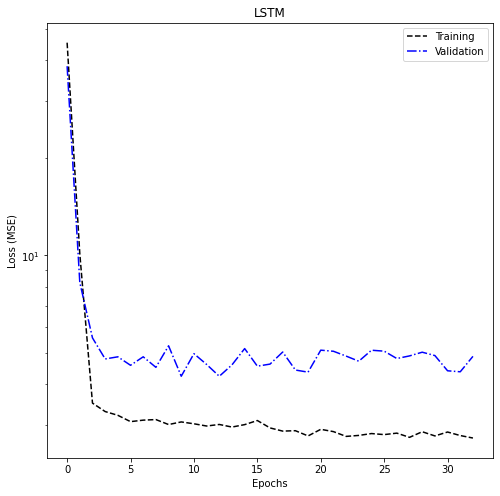

In [15]:
%%skip $SKIP_RETRAIN_LSTM

fig = plot_learning_curves(histLSTM,'LSTM','./LSTM/learning_curve_LSTM.png')
fig.show()

Load best model

In [16]:
#Calling back the best model:
model_best_LSTM = keras.models.load_model("./LSTM/my_best_LSTM_model.h5")
model_best_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 32)          7552      
_________________________________________________________________
batch_normalization (BatchNo (None, None, 32)          128       
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 32)          128       
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [17]:
y_test_filtered = data_y_test0.loc[idx_test]
y_test_filtered =y_test_filtered.squeeze(axis=1)
Y_test_predictions = pd.Series(model_best_LSTM.predict(data_x_test).flatten(),index=y_test_filtered.index)


In [18]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

<ipython-input-19-8f3049a6a1b7>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


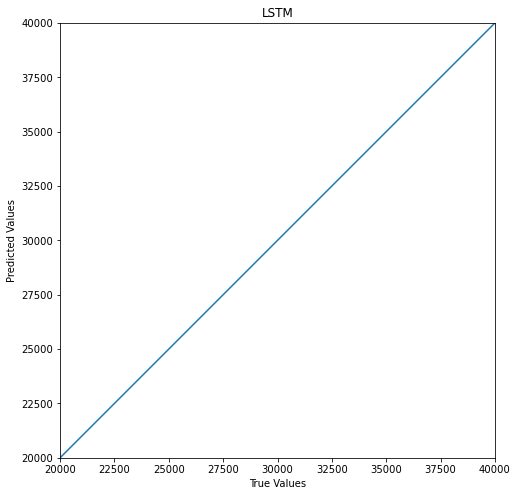

In [19]:
fig = plot_accuracy(eval_df,'LSTM',"./LSTM/accuracy_LSTM.png")
fig.show()

<ipython-input-20-ac0d7f1f6964>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


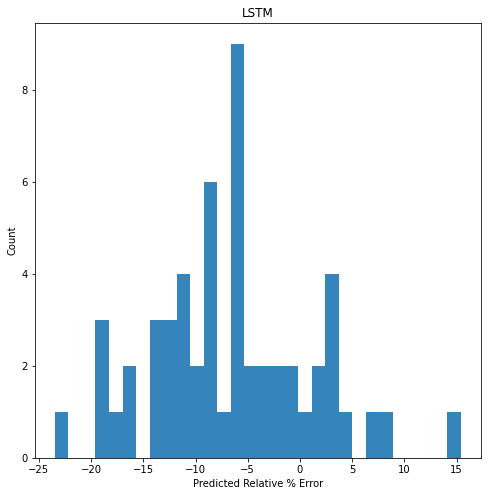

In [20]:
fig = plot_error_variations(eval_df,'LSTM',"./LSTM/error_variations_LSTM.png")
fig.show()

In [21]:
#Calculating the mean absolutepercentage error:
abs_error_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_LSTM)

8.467427731754888

In [22]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.74


<ipython-input-23-4006464a61a2>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


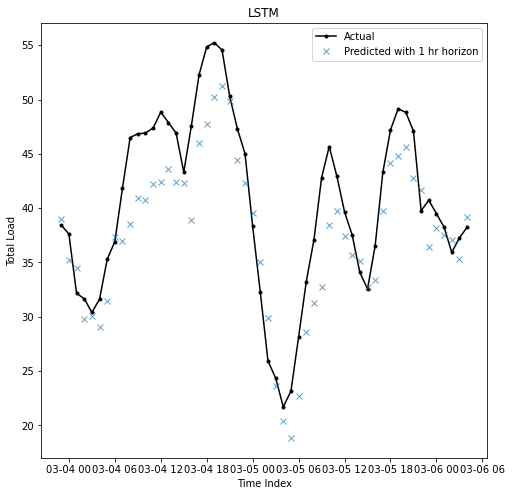

In [23]:
fig = plot_predictions(eval_df,1,'LSTM','Total Load',"./LSTM/predictions_LSTM")
fig.show()

# Multistep LSTM

Scale the input data

In [45]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [46]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-07'
feature = 'price actual'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [47]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,72,24,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,72,24,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,72,24,32)


In [48]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(17416, 72, 26) (17416, 24)
(1288, 72, 26) (1288, 24)
(8, 72, 26) (8, 24)


Define LSTM Model

In [49]:
def build_model_LSTM(data_x_train,data_y_train):
  n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
  model = models.Sequential([
  layers.LSTM(32, return_sequences=True,input_shape=(None, n_features), stateful=False), 
  layers.BatchNormalization(),
  layers.LSTM(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(32, stateful=False),
  layers.BatchNormalization(),
  layers.Dense(n_outputs)                     
  ])
  model.compile(optimizer='Adam',loss='mae',metrics='mse') 
  return model

Definening callback functions

In [50]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint("./LSTM/my_best_MS_LSTM_model.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

Hypterparameters

In [51]:
num_epochs = 150
batch_size = 32

Training the model

In [52]:
%%skip $SKIP_RETRAIN_LSTM

model_LSTM = build_model_LSTM(data_x_train,data_y_train)
history_LSTM = model_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])#, verbose=0)

Epoch 1/150
545/545 [==============================] - 14s 20ms/step - loss: 46.1450 - mse: 2389.5913 - val_loss: 52.1044 - val_mse: 2974.3879
Epoch 2/150
545/545 [==============================] - 10s 19ms/step - loss: 12.4725 - mse: 275.5341 - val_loss: 17.5074 - val_mse: 423.9775
Epoch 3/150
545/545 [==============================] - 11s 19ms/step - loss: 6.9735 - mse: 82.1103 - val_loss: 19.3723 - val_mse: 502.5536
Epoch 4/150
545/545 [==============================] - 10s 19ms/step - loss: 6.7439 - mse: 77.9573 - val_loss: 17.8850 - val_mse: 436.3778
Epoch 5/150
545/545 [==============================] - 10s 19ms/step - loss: 6.5851 - mse: 74.8927 - val_loss: 18.4531 - val_mse: 459.6287
Epoch 6/150
545/545 [==============================] - 11s 20ms/step - loss: 6.3943 - mse: 70.9916 - val_loss: 18.0590 - val_mse: 442.5821
Epoch 7/150
545/545 [==============================] - 11s 20ms/step - loss: 6.1303 - mse: 65.5522 - val_loss: 17.3199 - val_mse: 413.2240
Epoch 8/150
545/545 [

Evaluate the training process

In [53]:
%%skip $SKIP_RETRAIN_LSTM

histLSTM = pd.DataFrame(history_LSTM.history)
histLSTM['epoch'] = history_LSTM.epoch

<string>:3: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



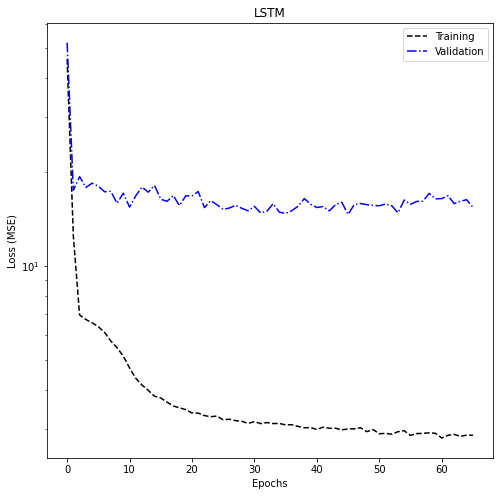

In [54]:
%%skip $SKIP_RETRAIN_LSTM

fig = plot_learning_curves(histLSTM,'LSTM','./LSTM/learning_curve_MS_LSTM.png')
fig.show()

Load best model

In [55]:
#Calling back the best model:
model_best_MS_LSTM = keras.models.load_model("./LSTM/my_best_MS_LSTM_model.h5")
model_best_MS_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, None, 32)          7552      
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 32)          128       
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 32)          128       
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 24)               

In [56]:
i=1
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))

Y_test_predictions = pd.Series(model_best_MS_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered = data_y_test0.loc[Y_test_predictions.index]


In [57]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

<ipython-input-58-002f5216c571>:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



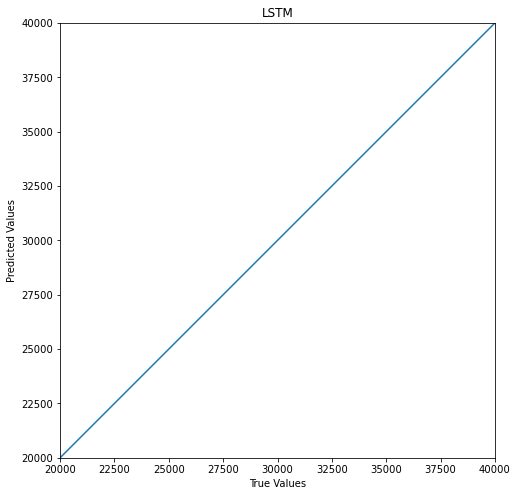

In [58]:
fig = plot_accuracy(eval_df,'LSTM',"./LSTM/accuracy_MS_LSTM.png")
fig.show()

<ipython-input-59-b9b05ae7d6d5>:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



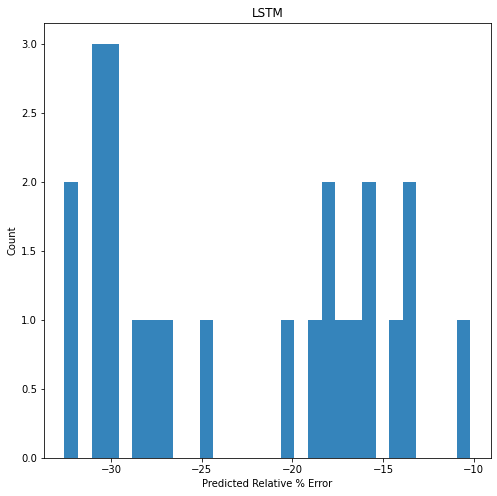

In [59]:
fig = plot_error_variations(eval_df,'LSTM',"./LSTM/error_variations_MS_LSTM.png")
fig.show()

In [60]:
#Calculating the mean absolutepercentage error:
abs_error_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_LSTM)

nan

In [61]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  -1.29


<ipython-input-62-161e8ab2ef2d>:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



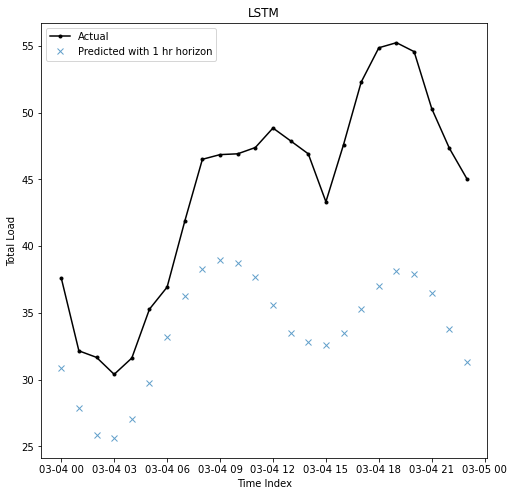

In [62]:
fig = plot_predictions(eval_df,1,'LSTM','Total Load',"./LSTM/predictions_MS_LSTM")
fig.show()

In [63]:
idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
y_test_filtered2 = data_y_test0.loc[idx_prediction]

In [64]:
fig = go.Figure()
df_pred =pd.DataFrame(index=y_test_filtered2.index)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=y_test_filtered2['price actual']))
for i in range(len(data_x_test)):
    case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
    Y_test_predictions = pd.Series(model_best_MS_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
    df_pred[f'pred_{i}'] = Y_test_predictions
    fig.add_trace(go.Scatter(x = Y_test_predictions.index,y=Y_test_predictions,mode='markers'))

df_pred['mean'] = df_pred.mean(axis=1)
df_pred['median'] = df_pred.median(axis=1)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['mean']))
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['median']))
fig.show()
eval_df2  =create_eval_df(df_pred['mean'],y_test_filtered2)

In [65]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered2[:-1],df_pred['mean'][:-1])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  -0.26
